# Introduction

Small businesses play a significant role in creating jobs and promoting economic growth in the United States. To support small businesses, the Small Business Administration (SBA) guarantees bank loans to reduce the risk for banks in lending to small businesses. However, the rate of loan defaults is very high, and many economists question the effectiveness of the SBA's support. In this data science project, we will analyze a subset of the SBA loan database, which includes information on loans granted to the Real Estate and Rental and Leasing industry in California from 1987 to 2014. The data set contains 2,102 observations and 35 variables, including the loan default status, which we will use to predict whether a loan will default. By analyzing this data, we aim to provide insights into the loan approval process for small businesses in the Real Estate and Rental and Leasing industry in California.  
Here's a [Kaggle link for the dataset](https://www.kaggle.com/datasets/larsen0966/sba-loans-case-data-set)

Problem Statement: The objective of this data science project is to develop a predictive model that can accurately identify potential loan defaults based on historical customer data. By leveraging machine learning algorithms and analyzing various features such as income, credit score, and employment history, the goal is to provide the lending institution with a tool to assess loan applicants' creditworthiness and mitigate the risk of default.

In [1]:
%matplotlib inline

# 1.Imports and reading the data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from nose.tools import *
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score,f1_score, roc_auc_score,confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss, average_precision_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

Reading the data

In [3]:
loans_data = pd.read_csv('data/SBAcase.11.13.17.csv')

# 2.Data quality,preparation and cleaning

To start, let's take a look at the data types of the columns and if they align with what we expect them to be.

In [4]:
loans_data.dtypes

Selected               int64
LoanNr_ChkDgt          int64
Name                  object
City                  object
State                 object
Zip                    int64
Bank                  object
BankState             object
NAICS                  int64
ApprovalDate           int64
ApprovalFY             int64
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
ChgOffDate           float64
DisbursementDate     float64
DisbursementGross      int64
BalanceGross           int64
MIS_Status            object
ChgOffPrinGr           int64
GrAppv                 int64
SBA_Appv               int64
New                    int64
RealEstate             int64
Portion              float64
Recession              int64
daysterm               int64
xx                   float64
Default       

The dates are a float which isn't ideal but we will deal with them further down the line. 

We observed from the documentation that 'RevLineCr' and 'LowDoc' variables have values of 'Y' and 'N'.  
We want to convert these variables into numeric values of ones and zeros.

In [5]:
loans_data['RevLineCr'] = loans_data['RevLineCr'].map({'Y': 1, 'N': 0})
loans_data['LowDoc'] = loans_data['LowDoc'].map({'Y': 1, 'N': 0})

Okay, now that that's done we can start focusing on the null values.  
Firstly, let's calculate the percentage of null values for all the different variables we have.

In [6]:
na_percentages = (loans_data.isnull().sum() / len(loans_data)) * 100
print(na_percentages)

Selected              0.000000
LoanNr_ChkDgt         0.000000
Name                  0.000000
City                  0.000000
State                 0.000000
Zip                   0.000000
Bank                  0.142721
BankState             0.142721
NAICS                 0.000000
ApprovalDate          0.000000
ApprovalFY            0.000000
Term                  0.000000
NoEmp                 0.000000
NewExist              0.047574
CreateJob             0.000000
RetainedJob           0.000000
FranchiseCode         0.000000
UrbanRural            0.000000
RevLineCr            37.345385
LowDoc                0.380590
ChgOffDate           66.841104
DisbursementDate      0.142721
DisbursementGross     0.000000
BalanceGross          0.000000
MIS_Status            0.000000
ChgOffPrinGr          0.000000
GrAppv                0.000000
SBA_Appv              0.000000
New                   0.000000
RealEstate            0.000000
Portion               0.000000
Recession             0.000000
daysterm

Now the number of null values.

In [7]:
na_counts = loans_data.isnull().sum()
print(na_counts)

Selected                0
LoanNr_ChkDgt           0
Name                    0
City                    0
State                   0
Zip                     0
Bank                    3
BankState               3
NAICS                   0
ApprovalDate            0
ApprovalFY              0
Term                    0
NoEmp                   0
NewExist                1
CreateJob               0
RetainedJob             0
FranchiseCode           0
UrbanRural              0
RevLineCr             785
LowDoc                  8
ChgOffDate           1405
DisbursementDate        3
DisbursementGross       0
BalanceGross            0
MIS_Status              0
ChgOffPrinGr            0
GrAppv                  0
SBA_Appv                0
New                     0
RealEstate              0
Portion                 0
Recession               0
daysterm                0
xx                      3
Default                 0
dtype: int64


We would like to create a dataframe with the percentage of null values as well as their counts.

We start by ensuring na_counts and na_percentages have consistent column names with loans_data.

In [8]:
na_counts.index = loans_data.columns
na_percentages.index = loans_data.columns

We then create a list of column names present in loans_data and filter na_counts and na_percentages to include only columns present in loans_data.

In [9]:
column_names = loans_data.columns.tolist()
na_counts = na_counts[column_names]
na_percentages = na_percentages[column_names]

In [10]:
na_table = pd.DataFrame({
    'Variable': na_counts.index,
    'NA Count': na_counts,
    'NA Percentage': na_percentages
})

In [11]:
na_table

,Variable,NA Count,NA Percentage
Selected,Selected,0,0.000000
LoanNr_ChkDgt,LoanNr_ChkDgt,0,0.000000
Name,Name,0,0.000000
City,City,0,0.000000
State,State,0,0.000000
Zip,Zip,0,0.000000
Bank,Bank,3,0.142721
BankState,BankState,3,0.142721
NAICS,NAICS,0,0.000000
ApprovalDate,ApprovalDate,0,0.000000


At the outset, we observe that ChgOffDate contains a significant number of null values. However, this is not surprising since ChgOffDate is populated only when a business' loan is charged off. For businesses that have fully repaid their loans, this field will be null.

As we can see in the below code - almost all the populated values are companies that have defaulted on their loans.

In [12]:
default_percent = (loans_data[loans_data.ChgOffDate.notnull()]['Default'].sum() / 
                   loans_data[loans_data.ChgOffDate.notnull()].shape[0]) * 100

In [13]:
print(default_percent)

98.42180774748924


I find that the percentage of 98.42 is high enough to warrant a removal of ChgOffDate as a variable to the model as it will not yield any new information - the n/a values are the companies who haven't defaulted and the ones that are populated have a default rate of 98.42%.

The 'Selected' column in the dataset is a pre-defined variable used for splitting the data into train and test datasets. However, since we plan to perform our own data splitting later on, we can safely remove this variable from the dataset.

In [14]:
loans_data.drop(['Selected'],axis=1,inplace=True)

Now let's drop the columns that we mentioned above - the ones that contain a date plus some unnecesary ones like NAICS - that won't be used in the following analysis.  
Here's what each one corresponds to:  
ApprovalFY - Fiscal year of commitment  
DisbursementDate - Disbursement date  
ApprovalDate - Approval date  
ChgOffDate - We already mentioned this - the date that the loan was charged off.  
Selected - We already mentioned that this is whether the data will be used for training or testing purposes.  
LoanNr_ChkDgt - This is the primary key and we won't be needing that for this analysis.  
NAICS - North American industry classification system code  
FranchiseCode - Franchise code, (00000 or 00001) = No franchise  
daysterm - extra variable that was created when the Recession variable was created  
xx - like the above

In [15]:
loans_data = loans_data.drop(['ApprovalFY','DisbursementDate','ApprovalDate','ChgOffDate','LoanNr_ChkDgt','NAICS','FranchiseCode','daysterm','xx'],axis = 1)

I have decided to drop the small number of missing values that occur outside of 'ChgOffDate'. This decision was made based on the table above which shows that the number of missing values is relatively small, and dropping them is unlikely to have a significant impact on the analysis. 

In [16]:
loans_data.dropna(inplace=True)

Quick check if any n/a values are left out.

In [17]:
loans_data.isnull().sum()

Name                 0
City                 0
State                0
Zip                  0
Bank                 0
BankState            0
Term                 0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementGross    0
BalanceGross         0
MIS_Status           0
ChgOffPrinGr         0
GrAppv               0
SBA_Appv             0
New                  0
RealEstate           0
Portion              0
Recession            0
Default              0
dtype: int64

During the analysis, an unexpected value of 0 was discovered in the 'NewExist' variable, which is typically assigned a value of 1 or 2 to indicate whether a business is existing or new. Since this value appears to be an anomaly and there is only one occurrence, it will be removed from the dataset.

In [18]:
loans_data.drop(loans_data[loans_data['NewExist']==0].index,inplace=True)

The next step is to split the dataset into training and testing data. It will be used to evaluate our model further down the line.

In [19]:
loans_data_train, loans_data_test = train_test_split(loans_data, test_size=0.2, random_state=42)

In [20]:
print("Train data shape:", loans_data_train.shape)
print("Test data shape:", loans_data_test.shape)

Train data shape: (1044, 25)
Test data shape: (261, 25)


I have decided to create a subset of the dataset that excludes the 'Default' variable,  
which will be our target variable for further analysis and modeling in this data science project.

In [21]:
independent_vars = [col for col in loans_data.columns if col != 'Default']
loans_data_subset = loans_data_test[independent_vars]

# 3. Explanatory Data Analysis

Okay now let's start some data exploration.  
I have picked several variables which I believe influence the Default rate.  
Term - the loan term in months (non-binary)  
NoEmp - number of employees at the time of the loan (non-binary)    
NewExist - new or existing business (binary)  
UrbanRural - the geographical location of the business (binary)    
RealEstate - whether or not the business was backed by real estate (binary)  
Recession - whether the loan was given during the Great Recession or not (binary var)  

## 3.1 Exploration of Term
To begin with, let's take a look at a density plot of the loan term and see what that can tell us.

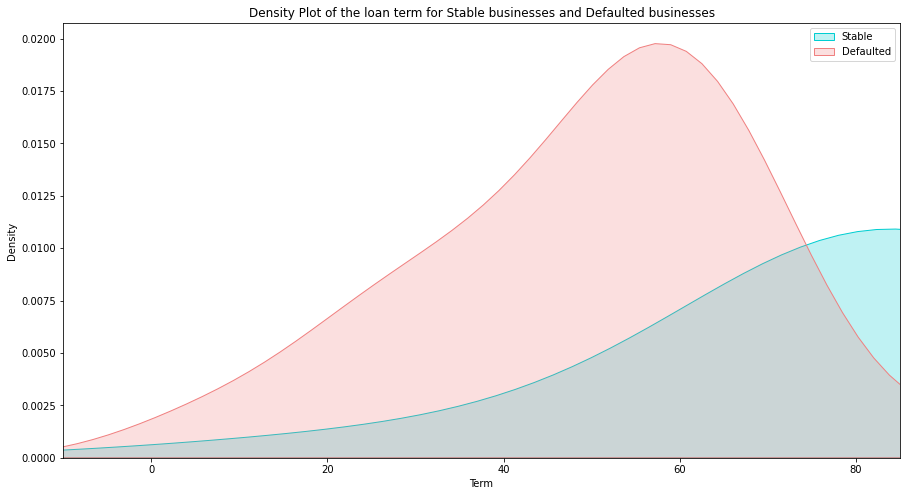

In [22]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(loans_data_train["Term"][loans_data_train.Default == 0], color="darkturquoise", shade=True)
sns.kdeplot(loans_data_train["Term"][loans_data_train.Default == 1], color="lightcoral", shade=True)
plt.legend(['Stable', 'Defaulted'])
plt.title('Density Plot of the loan term for Stable businesses and Defaulted businesses')
ax.set(xlabel='Term')
plt.xlim(-10,85)
plt.show()

It is evident that most of the businesses that defaulted had shorter-term loans. The default rate rises gradually up to around 50 months, after which it starts to decrease steadily. Conversely, longer-term loans appear to be more stable, with a lower default rate observed in this category.

## 3.2 Exploration of number of employees 
Now let's take a look at our next variable - number of employees.

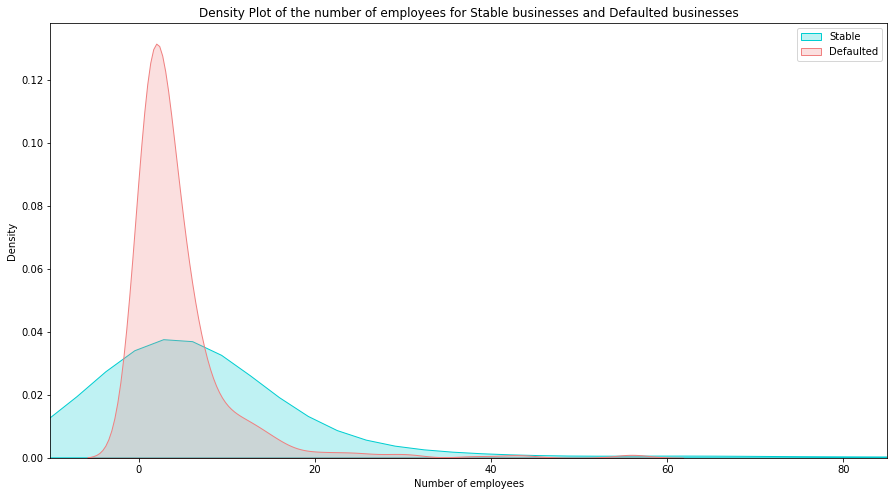

In [23]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(loans_data_train["NoEmp"][loans_data_train.Default == 0], color="darkturquoise", shade=True)
sns.kdeplot(loans_data_train["NoEmp"][loans_data_train.Default == 1], color="lightcoral", shade=True)
plt.legend(['Stable', 'Defaulted'])
plt.title('Density Plot of the number of employees for Stable businesses and Defaulted businesses')
ax.set(xlabel='Number of employees')
plt.xlim(-10,85)
plt.show()

The distribution in this variable is clearly different for our two categories. It's likely that this variable will be a significant predictor in our final model. The businesses that have a smaller number of employees appear to have a higher chance of defaulting.

## 3.3 Exploration of whether the business was new or existing
Let's explore whether the default rate is influenced by the status of the business, either new or existing. Here,on the x axis, we can use the coding of 1 for existing businesses and 2 for new ones.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


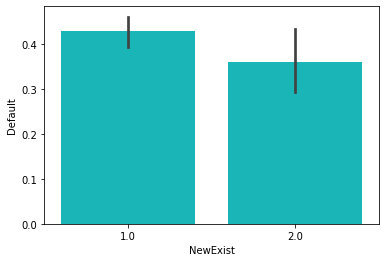

In [24]:
sns.barplot('NewExist', 'Default', data=loans_data_train, color="darkturquoise")
plt.show()

Upon analysis, it appears that new businesses have a slightly higher default rate, although not as high as one would anticipate. This observation came as a surprise to me.     

## 3.4 Exploration of geographical location
The next observation would be how the default rate varies based on the geographic location. The location variable has 3 categories: 0 for undefined, 1 for urban, and 2 for rural.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


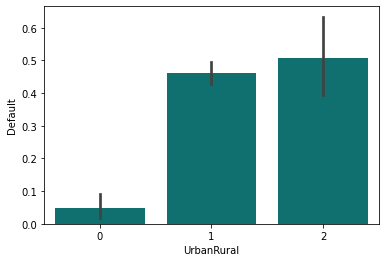

In [25]:
sns.barplot('UrbanRural', 'Default', data=loans_data_train, color="teal")
plt.show()

It looks like rural businesses have a higher chance of default - that might be due to the relative stability of the rural areas in terms of population and demand... which could be a good or bad thing depending on the case.

## 3.5 Exploration of real estate backing
Now let's take a look at real estate backing.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


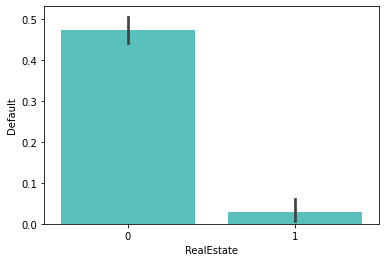

In [26]:
sns.barplot('RealEstate', 'Default', data=loans_data_train, color="mediumturquoise")
plt.show()

Unsurprisingly, real estate backing does bring down the default rate a lot.

## 3.6 Exploration of the period of the Great Recession
Now for our final variable - let's look at whether The Great Recession impacted the default rate.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


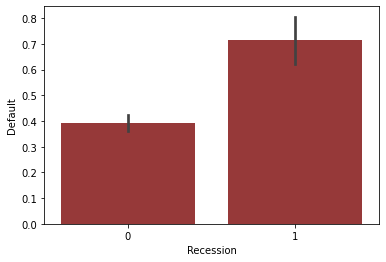

In [27]:
sns.barplot('Recession', 'Default', data=loans_data_train, color="brown")
plt.show()

Due to the nature of the recession this is not a surprise.

## 4.Modelling

## 4.1 Feature selection

By selecting the right set of features, we can improve model performance, reduce overfitting, and enhance interpretability. In this project, we will explore various feature selection techniques to identify the subset of features that have the strongest relationship with the target variable. This will allow us to focus on the most influential features and potentially eliminate redundant or irrelevant ones, leading to more robust and interpretable models.

In [28]:
X = loans_data_train[independent_vars]

In [29]:
y = loans_data_train['Default']

In [30]:
model = LogisticRegression()

Initially, pairwise correlations will be used to determine which are the highly correlated variables.Threshold is set at 0.8

In [31]:
threshold = 0.8

pairwise_correlations = X.corr().abs().unstack().sort_values(ascending=False)

highly_correlated_pairs = pairwise_correlations[pairwise_correlations > threshold]

print(highly_correlated_pairs)

Recession          Recession            1.000000
RevLineCr          RevLineCr            1.000000
New                New                  1.000000
                   NewExist             1.000000
SBA_Appv           SBA_Appv             1.000000
GrAppv             GrAppv               1.000000
ChgOffPrinGr       ChgOffPrinGr         1.000000
DisbursementGross  DisbursementGross    1.000000
UrbanRural         UrbanRural           1.000000
Portion            Portion              1.000000
RetainedJob        RetainedJob          1.000000
CreateJob          CreateJob            1.000000
NewExist           New                  1.000000
                   NewExist             1.000000
NoEmp              NoEmp                1.000000
Term               Term                 1.000000
RealEstate         RealEstate           1.000000
LowDoc             LowDoc               1.000000
Zip                Zip                  1.000000
SBA_Appv           GrAppv               0.989544
GrAppv             S

Based on this we can remove SBA_Appv, GrAppv and RealEstate and New to address multicollinearity.

In [32]:
X = X.drop(['SBA_Appv','GrAppv','RealEstate','New'],axis=1)

We will drop the variables that contain string values, such as names (e.g., Name), location information (e.g., City, State), and other text-based columns. These variables do not provide numerical information that can be used for modeling and prediction.

In [33]:
X = X.drop(['Name','City','State','Bank','BankState','MIS_Status'],axis=1)

We can also drop features that have a low variability. That is because features with minimal to no variation don't contribute to explaining the different instances within the dataset. The features won't be used for modelling as they might introduce noise. We are going to use VarianceTreshold to address this with a threshold of 0.1.

In [34]:
threshold = 0.1

selector = VarianceThreshold(threshold=threshold)

selector.fit(X)

selected_indices = selector.get_support(indices=True)

X_selected = X.iloc[:, selected_indices]

dropped_indices = np.logical_not(selector.get_support())
dropped_features = X.columns[dropped_indices]
print("Dropped features:")
print(dropped_features)

Dropped features:
Index(['LowDoc', 'BalanceGross', 'Portion', 'Recession'], dtype='object')


Let's print the variances in a dataframe.

In [35]:
variances = selector.variances_

variance_df = pd.DataFrame({'Feature': X.columns, 'Variance': variances})

variance_df = variance_df.sort_values('Variance', ascending=False)

variance_df['Variance'] = variance_df['Variance'].map('{:.4f}'.format)

print(variance_df.to_string(index=False))

           Feature          Variance
 DisbursementGross  74424194601.1769
      ChgOffPrinGr   4830460635.6867
               Zip      3106447.1057
              Term         5380.4301
             NoEmp          623.0508
       RetainedJob          171.4782
         CreateJob           53.7238
         RevLineCr            0.2464
        UrbanRural            0.1816
          NewExist            0.1495
         Recession            0.0683
           Portion            0.0301
            LowDoc            0.0132
      BalanceGross            0.0000


Now let's drop the 4 variables that have the lowest variance.

In [36]:
X = X.drop(['LowDoc','BalanceGross','Portion','Recession'],axis=1)

Next we are going to use SelectKBest to refine our feature selection.
It aims to identify the most informative features from a given dataset by evaluating their statistical significance. The technique assigns statistical scores to each feature and selects the top k features with the highest scores.
Additionally, selecting the most informative features can enhance model performance, as the model can focus on the most influential factors in making predictions or classifications.
It also provides a quantitative measure of feature importance, enabling us to prioritize features and gain insights into their contributions to the model's performance.

In [37]:
k = 5

selector = SelectKBest(score_func=chi2, k=k)

selector.fit(X, y)

selected_indices = selector.get_support(indices=True)

X_selected = X.iloc[:, selected_indices]
dropped_indices = np.logical_not(selector.get_support())
dropped_features = X.columns[dropped_indices]
print("Dropped features:")
print(dropped_features)

Dropped features:
Index(['Zip', 'NewExist', 'RetainedJob', 'UrbanRural', 'RevLineCr'], dtype='object')


Let's print a dataframe with the scores from set features and drop the fetures we don't need.

In [38]:
scores = selector.scores_

selected_features_df = pd.DataFrame({'Feature': X.columns[selected_indices], 'Score': scores[selected_indices]})

selected_features_df = selected_features_df.sort_values('Score', ascending=False)

selected_features_df = selected_features_df.reset_index(drop=True)

pd.options.display.float_format = '{:.4f}'.format

print("Selected Features:")
print(selected_features_df)

Selected Features:
             Feature         Score
0       ChgOffPrinGr 28370250.4391
1  DisbursementGross 24106605.9165
2               Term    12823.2843
3              NoEmp      845.6464
4          CreateJob      209.4766


In [39]:
X = X.drop(['Zip', 'NewExist', 'RetainedJob', 'UrbanRural', 'RevLineCr'],axis=1)

We have our features, now it's time to evaluate the model.

## 4.2 Model evaluation

### 4.2.1 Train/test split

We are going to use two model evaluation techniques.  
The first one is Train/test split. The primary reason for using it is to check the model's generalisation performance.
By seeing how the model performs on unseen data - the test split, we can establish how well it is going to perform on real world data. If the model performs well on the training set but worse on the testing set, then we can conclude that it is likely that the model has overfit the data.

In classification problems we need to check the balance of the values in our dependent variable 'Default'.

In [40]:
dependent_variable = 'Default'

value_counts = loans_data_train[dependent_variable].value_counts()

print(value_counts)

0    609
1    435
Name: Default, dtype: int64


It appears our variable is slightly imbalanced with 0 having a higher count than 1.  
We can address this we will use SMOTE(Synthetic Minority Oversampling Technique). 
This technique generates synthetic examples of the minority class by going through existing instances. It helps in increasing the diversity of the minority class while avoiding overfitting.
Let's test_split first.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
smote = SMOTE()

In [43]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Now let's fit the model with our newly created smote train data.

### 4.2.2 Logistic Regression
Let's build our Logistic regression model.

In [44]:
logreg= LogisticRegression()
logreg.fit(X_train_smote,y_train_smote)
y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_prob)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_prob))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

Train/Test split results:
LogisticRegression accuracy is 0.976
LogisticRegression log_loss is 0.054
LogisticRegression auc is 0.999


Next, we will compute the confusion matrix and expand more on the results.

In [45]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

TPR = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print("True Positive Rate (TPR):", TPR)

TNR = cm[0, 0] / (cm[0, 0] + cm[0, 1])
print("True Negative Rate (TNR):", TNR)

auc_pr = average_precision_score(y_test, y_pred_prob)
print("AUC PR:", auc_pr)

balanced_accuracy = (TPR + TNR) / 2
print("Balanced Accuracy:", balanced_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[134   1]
 [  4  70]]
True Positive Rate (TPR): 0.9459459459459459
True Negative Rate (TNR): 0.9925925925925926
AUC PR: 0.998284748698498
Balanced Accuracy: 0.9692692692692693
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       135
           1       0.99      0.95      0.97        74

    accuracy                           0.98       209
   macro avg       0.98      0.97      0.97       209
weighted avg       0.98      0.98      0.98       209



The confusion matrix shows the number of true positives (134), false positives (1), false negatives (5), and true negatives (69). It provides a comprehensive view of the model's performance in terms of correct and incorrect predictions.

True Positive Rate (TPR): 0.9459459459459459
The true positive rate, also known as recall or sensitivity, measures the proportion of actual positive instances that are correctly identified by the model. In this case, it indicates that the model correctly identified 94.59% of the true positive cases.

True Negative Rate (TNR): 0.9925925925925926
The true negative rate, also known as specificity, measures the proportion of actual negative instances that are correctly identified by the model. Here, it shows that the model correctly identified 99.26% of the true negative cases.

AUC PR (Area under Precision-Recall curve): 0.9980799984937478
The AUC PR score represents the area under the precision-recall curve, which indicates the model's performance in terms of precision and recall across different classification thresholds. A score close to 1 indicates a high-quality model that achieves high precision and recall.

Balanced Accuracy: 0.9692692692692693
The balanced accuracy is the average of the true positive rate and true negative rate. It provides a balanced measure of the model's performance, particularly in situations with imbalanced datasets. Here, the balanced accuracy is 96.93%.

Classification Report:
The classification report provides a comprehensive summary of various performance metrics, including precision, recall, and F1-score, for both the majority (0) and minority (1) classes. It also includes metrics such as support, which represents the number of instances in each class.

Overall, the model demonstrates strong performance with high precision, recall, and F1-score for both classes. The accuracy, as well as other metrics, indicate the model's ability to effectively handle the imbalanced dataset.

### 4.2.3 K-fold cross-validation
The second evaluation we can use is K fold cross validation.It will help us reduce the variance of the model's performance estimate as each sample is used for both training and validation.

We can use two functions for cross validation from the scikit learn library.  
The first one is cross_val_score() and the second one is cross_validate().  
So what is the difference between the two?  
Cross_val_score() is a simpler function as it only returns the scores for a single metric, while cross_validate() returns a dictionary with scores for diffrent metrics and also includes the fit/score times for each fold.  
Let's try both and see how they behave.

For cross_val_score we use cv = 10 for a 10 fold CV and we input the interety of X and y.
We use accuracy,neg_log_loss and roc_auc as metics.  
These are the results:  

In [46]:
logreg = LogisticRegression(max_iter=1000)
scores_accuracy = cross_val_score(logreg, X_train_smote, y_train_smote, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X_train_smote, y_train_smote, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X_train_smote, y_train_smote, cv=10, scoring='roc_auc')
print('K-fold cross-validation results:')
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average accuracy is 0.986
LogisticRegression average log_loss is 0.063
LogisticRegression average auc is 0.997


A bit more complex for cross_validate().

In [47]:
scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelCV = LogisticRegression(max_iter=1000)

results = cross_validate(modelCV, X_train_smote, y_train_smote, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)

print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(modelCV.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

K-fold cross-validation results:
LogisticRegression average accuracy: 0.986 (+/-0.009)
LogisticRegression average log_loss: 0.063 (+/-0.046)
LogisticRegression average auc: 0.997 (+/-0.005)


### 4.2.4 Other models

There are some other models that could be effective with classification - the two I have selected to use in this dataset for comparison are Random Forest and XGBoost.

Random Forest is a popular machine learning algorithm that combines multiple decision trees to make predictions. It creates a collection of trees by randomly selecting subsets of the training data and features. This randomness improves the model's ability to generalize and reduces overfitting.

Each decision tree is built independently by recursively splitting the data based on selected features. During prediction, the trees vote or average their results to make the final prediction. Random Forests are widely used due to their accuracy, robustness, and feature importance analysis.

XGBoost is a powerful gradient boosting framework used in machine learning. It combines multiple weak models, usually decision trees, to create a strong predictive model. XGBoost improves upon traditional gradient boosting by incorporating regularization techniques and efficient algorithm design. It is highly scalable, and offers excellent predictive accuracy.XGBoost is widely used for its accuracy, scalability, and ability to handle complex datasets.

In [48]:
# Random Forest
param_grid_rf = {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10]}
rf = RandomForestClassifier()
grid_rf = GridSearchCV(rf, param_grid_rf, scoring='accuracy', cv=10, refit='Accuracy')
grid_rf.fit(X_train_smote, y_train_smote)
best_rf = grid_rf.best_estimator_

# XGBoost
param_grid_xgb = {'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [3, 5, 7], 'n_estimators': [100, 200, 300]}
xgb_model = xgb.XGBClassifier()
grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, scoring='accuracy', cv=10, refit='Accuracy')
grid_xgb.fit(X_train_smote, y_train_smote)
best_xgb = grid_xgb.best_estimator_

# Logistic Regression
param_grid_lr = {'C': np.logspace(-3, 2, 10)}
lr = LogisticRegression(max_iter=1000)
grid_lr = GridSearchCV(lr, param_grid_lr, scoring='accuracy', cv=10, refit='Accuracy')
grid_lr.fit(X_train_smote, y_train_smote)
best_lr = grid_lr.best_estimator_

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:42] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:42] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:42] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:42] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:42] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:42] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:43] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:43] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:43] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:43] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:43] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:43] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:43] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:43] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:43] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:43] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:43] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:44] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:44] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:44] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:44] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:44] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:44] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:44] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:44] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:44] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:45] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:45] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:45] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:45] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:45] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:45] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:45] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:45] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:45] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:45] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:46] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:46] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:46] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:46] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:46] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:46] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:46] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:46] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:46] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:46] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:47] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:47] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:47] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:47] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:47] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:47] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:47] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:47] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:47] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:47] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:47] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:47] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:48] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:48] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:48] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:48] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:48] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:48] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:48] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:48] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:48] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:48] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:48] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:49] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:49] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:49] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:49] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:49] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:49] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:49] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:49] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:49] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:50] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:50] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:50] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:50] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:50] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:50] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:50] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:50] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:50] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:50] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:50] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:51] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:51] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:51] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:51] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:51] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:51] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:51] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:51] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:51] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:51] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:52] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:52] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:52] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:52] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:52] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:52] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:52] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:52] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:52] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:52] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:52] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:52] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:53] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:53] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:53] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:53] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:53] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:53] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:53] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:53] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:53] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:53] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:53] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:53] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:54] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:54] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:54] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:54] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:54] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:54] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:54] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:54] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:54] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:54] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:54] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:55] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:55] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:55] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:55] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:55] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:55] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:55] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:55] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:55] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:55] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:55] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:55] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:56] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:56] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:56] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:56] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:56] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:56] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:56] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:56] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:56] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:56] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:57] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:57] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:57] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:57] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:57] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:57] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:57] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:57] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:57] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:57] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:57] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:57] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:57] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:57] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:58] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:58] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:58] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:58] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:58] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:58] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:58] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:58] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:58] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:58] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:59] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:59] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:59] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:59] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:59] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:59] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:59] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:59] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:59] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:59] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:59] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:59] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:20:59] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:59] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:00] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:21:00] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:00] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:00] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:21:00] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:00] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:00] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:21:00] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:00] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:00] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:21:00] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:01] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:01] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:21:01] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:01] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:01] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:21:01] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:01] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:01] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:21:01] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:01] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:01] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:21:01] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:02] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:02] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:21:02] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:02] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:02] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:21:02] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:02] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:21:02] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:03] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:21:03] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:03] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:03] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/sr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

[19:21:03] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:21:03] WARNING: /private/var/folders/5j/076zx5bn05l7x2f2nsy4pvmh0000gn/T/pip-install-4uae_enj/xgboost_83298de548ce4688a6bffabe59404bf5/build/temp.macosx-10.6-intel-3.6/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Now that we have our three models it's time to evaluate them.

In [49]:

# Random Forest
rf_predictions = best_rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)
rf_auc = roc_auc_score(y_test, rf_predictions)

# XGBoost
xgb_predictions = best_xgb.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_precision = precision_score(y_test, xgb_predictions)
xgb_recall = recall_score(y_test, xgb_predictions)
xgb_f1 = f1_score(y_test, xgb_predictions)
xgb_auc = roc_auc_score(y_test, xgb_predictions)

# Logistic Regression
lr_predictions = best_lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_precision = precision_score(y_test, lr_predictions)
lr_recall = recall_score(y_test, lr_predictions)
lr_f1 = f1_score(y_test, lr_predictions)
lr_auc = roc_auc_score(y_test, lr_predictions)

print("Random Forest:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)
print("AUC:", rf_auc)

print("\nXGBoost:")
print("Accuracy:", xgb_accuracy)
print("Precision:", xgb_precision)
print("Recall:", xgb_recall)
print("F1 Score:", xgb_f1)
print("AUC:", xgb_auc)

print("\nLogistic Regression:")
print("Accuracy:", lr_accuracy)
print("Precision:", lr_precision)
print("Recall:", lr_recall)
print("F1 Score:", lr_f1)
print("AUC:", lr_auc)

Random Forest:
Accuracy: 0.9856459330143541
Precision: 0.9863013698630136
Recall: 0.972972972972973
F1 Score: 0.979591836734694
AUC: 0.9827827827827827

XGBoost:
Accuracy: 0.9952153110047847
Precision: 0.9866666666666667
Recall: 1.0
F1 Score: 0.9932885906040269
AUC: 0.9962962962962962

Logistic Regression:
Accuracy: 0.9760765550239234
Precision: 0.9859154929577465
Recall: 0.9459459459459459
F1 Score: 0.9655172413793103
AUC: 0.9692692692692693


High accuracy on all of them, let's plot these results in a line plot.

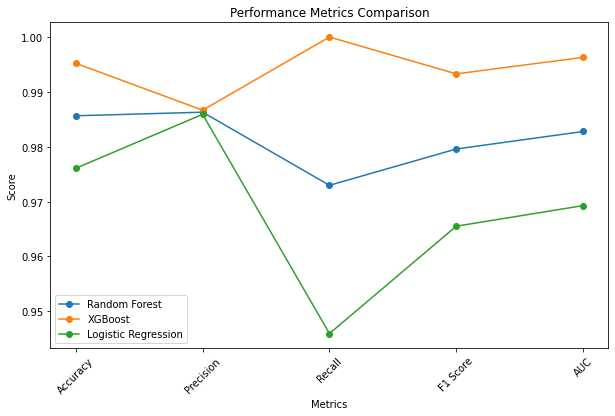

In [50]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
rf_values = [rf_accuracy, rf_precision, rf_recall, rf_f1, rf_auc]
xgb_values = [xgb_accuracy, xgb_precision, xgb_recall, xgb_f1, xgb_auc]
lr_values = [lr_accuracy, lr_precision, lr_recall, lr_f1, lr_auc]

plt.figure(figsize=(10, 6))
plt.plot(metrics, rf_values, marker='o', label='Random Forest')
plt.plot(metrics, xgb_values, marker='o', label='XGBoost')
plt.plot(metrics, lr_values, marker='o', label='Logistic Regression')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.xticks(rotation=45)

plt.legend()

plt.show()


From the results and the line plot, it is evident that XGBoost outperformed the other two models across multiple performance metrics. Notably, XGBoost achieved a significantly higher Recall score, indicating its ability to correctly identify a larger proportion of positive instances. This superior performance in Recall suggests that XGBoost has a lower chance of missing relevant cases, making it more suitable for tasks where identifying all positive instances is crucial.
In our specific case of predicting loan defaults, it is critical to identify all positive instances accurately. Missing even a single positive instance can have significant consequences, such as financial loss. In such scenarios, maximizing the Recall metric becomes crucial.

I would also like to explore the feature importance in each of the three models.

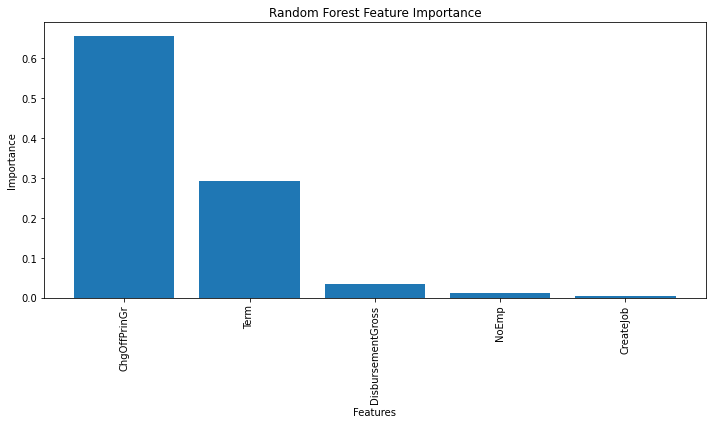

In [51]:
importances_rf = best_rf.feature_importances_

feature_names = X.columns

indices_rf = np.argsort(importances_rf)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances_rf)), importances_rf[indices_rf])
plt.xticks(range(len(importances_rf)), feature_names[indices_rf], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()


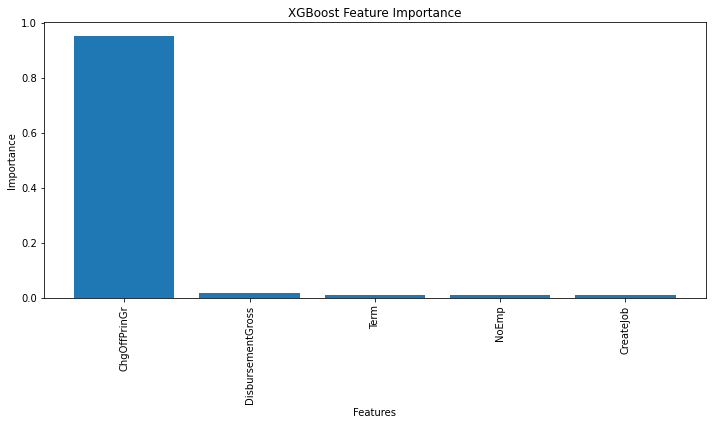

In [52]:
importances_xgb = best_xgb.feature_importances_

indices_xgb = np.argsort(importances_xgb)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances_xgb)), importances_xgb[indices_xgb])
plt.xticks(range(len(importances_xgb)), feature_names[indices_xgb], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

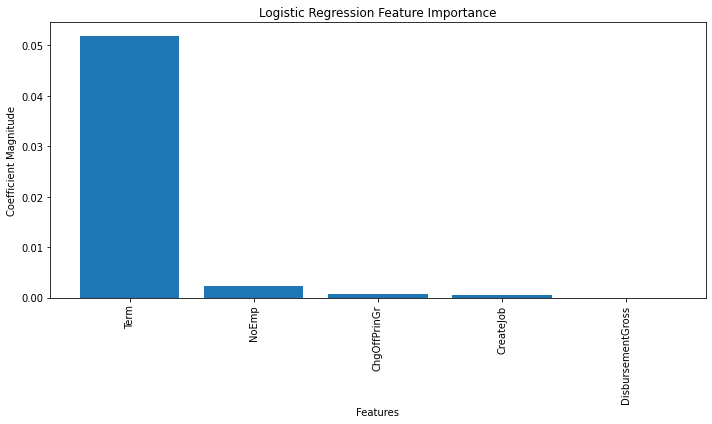

In [53]:
coefficients_lr = best_lr.coef_[0]

indices_lr = np.argsort(np.abs(coefficients_lr))[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients_lr)), np.abs(coefficients_lr)[indices_lr])
plt.xticks(range(len(coefficients_lr)), feature_names[indices_lr], rotation=90)
plt.xlabel('Features')
plt.ylabel('Coefficient Magnitude')
plt.title('Logistic Regression Feature Importance')
plt.tight_layout()
plt.show()


The feature importance results indicate the relative significance of different features in predicting the target variable across the three models: XGBoost, Random Forest, and Logistic Regression. Specifically, we observe that the feature "ChgOffPrinGr" appears to be the most important in both XGBoost and Random Forest, while the feature "Term" is deemed most important in Logistic Regression.

XGBoost and Random Forest: The prominence of the "ChgOffPrinGr" feature in both XGBoost and Random Forest suggests its strong influence on predicting the target variable. It implies that the amount of charged-off principal, which represents the unpaid loan amount, carries significant predictive power in determining the outcome.In these models, the feature importance is typically determined by evaluating how much the inclusion of a particular feature improves the overall predictive performance across all the trees in the ensemble. These algorithms consider various factors such as the feature's ability to split the data effectively and reduce the impurity of the target variable.

Logistic Regression: In contrast, Logistic Regression identifies the "Term" feature as the most important. The "Term" refers to the duration or length of the loan. It implies that the duration of the loan is a significant factor in determining whether a default or non-default outcome will occur. In this algorithm, feature importance is derived from the coefficients assigned to each feature. The magnitude of these coefficients indicates the strength and direction of the relationship between the feature and the target variable. Features with larger coefficients have a greater impact on the predicted probability and are thus deemed more important.